<a href="https://colab.research.google.com/github/daklima/backtests-ibov-cbs/blob/master/Compra_CBs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

In [202]:
!pip install xirr
import xirr
# https://pypi.org/project/xirr/

In [203]:
# Parâmetros da análise
start_date = '01/07/1994'
end_date = '31/07/2020'  # Dados até 06/08/2020
circuit_breakers_dates = ['05/09/1994', '27/10/1997', '07/11/1997', '12/11/1997', '21/08/1998', '04/09/1998',
                          '10/09/1998', '17/09/1998', '13/01/1999', '14/01/1999', '11/09/2001', '29/09/2008',
                          '06/10/2008', '10/10/2008', '15/10/2008', '22/10/2008', '18/05/2017', '09/03/2020',
                          '11/03/2020', '12/03/2020', '16/03/2020', '18/03/2020']
dias_apos_cb = 21
idx_fee = 0.000  # BOVA11: 0.003
idx_tax_rate = 0.15
b3_fee = 0.0003068
cdi_tax_rate = {}
for i in range(0, 10000):
    if i < 181:
        cdi_tax_rate[i] = 0.225
    elif (i > 180) & (i < 361):
        cdi_tax_rate[i] = 0.2
    elif (i > 360) & (i < 721):
        cdi_tax_rate[i] = 0.175
    else:
        cdi_tax_rate[i] = 0.15
cdi_iof={}
cdi_iof[0]=1
for i in range(1, 10000):
  if ((i-1)%3 == 0) & (i <= 31):
    cdi_iof[i] = round(cdi_iof[i-1] - 0.04, 2)
  elif i <= 31:
    cdi_iof[i] = round(cdi_iof[i-1] - 0.03, 2)
  else:
    cdi_iof[i] = 0

idx_fee_daily = (1 + idx_fee) ** (1 / 252) - 1
valor_inicial_cota = 1

In [204]:
# Parâmetros dos gráficos
sns.set()
sns.set_style('darkgrid', {'axes.facecolor': '0.13',
                           'figure.facecolor': '0.1',
                           'grid.color': '0.1',
                           'axes.labelcolor': '.7',
                           'text.color': '.7',
                           'xtick.color': '.7',
                           'ytick.color': '.7',
                           'axes.spines.left': False,
                           'axes.spines.bottom': False,
                           'axes.spines.right': False,
                           'axes.spines.top': False})

In [205]:
# Lê dado dos índices
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')
idx_data = pd.read_csv('Ibov.csv',
                       delimiter=';', thousands='.', decimal=',', index_col='Data',
                       parse_dates=True, date_parser=dateparse)
cdi_data = pd.read_csv('CDI.csv',
                       delimiter=';', decimal=',', index_col='Data',
                       parse_dates=True, date_parser=dateparse)
ipca_data = pd.read_csv('IPCA.csv',
                       delimiter=';', decimal=',', index_col='Data',
                       parse_dates=True, date_parser=dateparse)

In [206]:
# Datas de análise (dd/mm/yyyy)
days = pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'),
                     freq='B')
months = pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'),
                       freq='M')
years = pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'),
                      freq='BY')
day_count = days.value_counts().sum()

In [215]:
# Cria dataframe com os variações diárias dos índices
df_idx_day = pd.DataFrame({'Date': days})
df_idx_day.set_index('Date', inplace=True)
df_idx_day['Close'] = idx_data.Ultimo
df_idx_day['PctChange'] = idx_data.Ultimo.pct_change()
df_idx_day['PctChange'].fillna(0, inplace=True)
df_idx_day['ReturnNoFees'] = (1 + df_idx_day.PctChange).cumprod()
df_idx_day['Return'] = (1 - idx_fee_daily) * df_idx_day.ReturnNoFees
df_idx_day['CDI_PctChange'] = cdi_data.Taxa
df_idx_day['CDI_PctChange'].fillna(0, inplace=True)
df_idx_day['CDI_Return'] = (1 + df_idx_day.CDI_PctChange).cumprod()

In [216]:
# Tranforma dataframe do ipca de mensal para diário.
dates_ipca_data = pd.date_range(ipca_data.index.min() - pd.DateOffset(day=1), ipca_data.index.max() + pd.DateOffset(day=31), freq='D')
dates_ipca_data.name = 'Date'
ipca_data = ipca_data.reindex(dates_ipca_data, method='ffill')

In [217]:
# Dataframe com IPCA
df_ipca = pd.DataFrame({'Date': pd.date_range(pd.to_datetime(start_date, format='%d/%m/%Y'), pd.to_datetime(end_date, format='%d/%m/%Y'), freq='D')})
df_ipca.set_index('Date', inplace=True)
df_ipca['Month'] = pd.to_datetime(df_ipca.index).month
df_ipca['PctChange'] = ipca_data.VarMensal
df_ipca = df_ipca[df_ipca.index.isin(days)]
df_ipca['PctChange'] = np.where(df_ipca.Month != df_ipca.Month.shift(-1), df_ipca.PctChange, 0)
df_ipca['Cumulative'] = (df_ipca.PctChange + 1).cumprod() - 1
df_ipca['RateUntilPresent'] = (1 + df_ipca.Cumulative[-1]) / (1 + df_ipca.Cumulative) - 1 

In [218]:
# Dataframe com cálculos carteira compra mensal
df_cm = pd.DataFrame({'Date': days})
df_cm.set_index('Date', inplace=True)
df_cm['idxDailyReturn'] = 1 + df_idx_day.PctChange
df_cm['Month'] = pd.to_datetime(df_cm.index).month
df_cm['Monthly_Investment'] = np.where(df_cm.Month != df_cm.Month.shift().fillna(0), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_cm['Invested_Capital'] = df_cm.Monthly_Investment.cumsum().fillna(0)
df_cm['Total_Capital'] = df_cm['Invested_Capital']
for day in range(1, day_count):
  df_cm.loc[df_cm.index[day], 'Total_Capital'] = (df_cm.loc[df_cm.index[day-1],'Total_Capital'] + 
                                                  df_cm.loc[df_cm.index[day], 'Monthly_Investment'] * (1 - b3_fee)) * df_cm.loc[df_cm.index[day], 'idxDailyReturn']

In [219]:
# Cálculo da rentabilidade carteira compra mensal
df_cm['Valor_Cota'] = 0
df_cm['Qtde_Cotas'] = 0
df_cm.loc[df_cm.index[0],'Valor_Cota'] = valor_inicial_cota
df_cm.loc[df_cm.index[0],'Qtde_Cotas'] = df_cm.loc[df_cm.index[0],'Total_Capital'] / df_cm.loc[df_cm.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_cm.loc[df_cm.index[day],'Qtde_Cotas'] = df_cm.loc[df_cm.index[day-1],'Qtde_Cotas'] + \
                                             df_cm.loc[df_cm.index[day],'Monthly_Investment'] / df_cm.loc[df_cm.index[day-1],'Valor_Cota']
  df_cm.loc[df_cm.index[day],'Valor_Cota'] = df_cm.loc[df_cm.index[day],'Total_Capital'] / df_cm.loc[df_cm.index[day],'Qtde_Cotas']

df_cm['Return'] = df_cm.Valor_Cota / valor_inicial_cota

In [220]:
# TIR
cash_flows_cm = -df_cm.Monthly_Investment.fillna(0)
cash_flows_cm[-1] = df_cm.Total_Capital[-1]
tir_cm = xirr.xirr(dict(zip(days.date, cash_flows_cm)))

# **CÁLCULO DAS ESTRATÉGIAS CAIXA NO CDI**

In [221]:
# Dataframe com cálculos carteira compra 1 dia após circuit breakers COM CDI
df_cdcb = pd.DataFrame({'Date': days})
df_cdcb.set_index('Date', inplace=True)

df_cdcb['idxDailyReturn'] = 1 + df_idx_day.PctChange
df_cdcb['CDIDailyReturn'] = 1 + df_idx_day.CDI_PctChange

df_cdcb['isCB'] = df_cdcb.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))
df_cdcb['CB_count'] = df_cdcb.isCB.cumsum()
df_cdcb['Month'] = pd.to_datetime(df_cdcb.index).month
df_cdcb['CDI_Monthly_Investment'] = np.where(df_cdcb.Month != df_cdcb.Month.shift().fillna(0), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_cdcb['Invested_Capital'] = df_cdcb.CDI_Monthly_Investment.cumsum()
df_cdcb['Days_Till_CB'] = df_cdcb.groupby((df_cdcb.isCB == 1).cumsum()).cumcount(ascending=False)+1

df_cdcb['CDI_Total_Capital'] = df_cdcb['CDI_Monthly_Investment']
df_cdcb['CDI_Tax_for_Current_Investment'] = 0
df_cdcb.loc[df_cdcb.index[0], 'CDI_Tax_for_Current_Investment'] = df_cdcb.loc[df_cdcb.index[0], 'CDI_Total_Capital'] * \
                                                                  cdi_tax_rate[df_cdcb.loc[df_cdcb.index[0], 'Days_Till_CB']] * \
                                                                  (1-cdi_iof[df_cdcb.loc[df_cdcb.index[0], 'Days_Till_CB']]) * \
                                                                  (np.prod(np.where((df_cdcb.CB_count == df_cdcb.loc[df_cdcb.index[0], 'CB_count'])  & (df_cdcb.Days_Till_CB <= df_cdcb.loc[df_cdcb.index[0], 'Days_Till_CB']), 
                                                                                    df_cdcb.CDIDailyReturn, 1)) - 1)     
df_cdcb['idx_Investment_After_CB'] = 0
df_cdcb['idx_Total_Capital'] = 0

for day in range(1, day_count):
  df_cdcb.loc[df_cdcb.index[day], 'CDI_Total_Capital'] = np.where(~df_cdcb.loc[df_cdcb.index[day-1], 'isCB'],
                                                                   (df_cdcb.loc[df_cdcb.index[day-1], 'CDI_Total_Capital'] + df_cdcb.loc[df_cdcb.index[day], 'CDI_Monthly_Investment']) * \
                                                                    df_cdcb.loc[df_cdcb.index[day], 'CDIDailyReturn'], 0)
  df_cdcb.loc[df_cdcb.index[day], 'CDI_Tax_for_Current_Investment'] = df_cdcb.loc[df_cdcb.index[day], 'CDI_Monthly_Investment'] * \
                                                                      cdi_tax_rate[df_cdcb.loc[df_cdcb.index[day], 'Days_Till_CB']] * \
                                                                      (1-cdi_iof[df_cdcb.loc[df_cdcb.index[day], 'Days_Till_CB']]) * \
                                                                      (np.prod(np.where((df_cdcb.CB_count == df_cdcb.loc[df_cdcb.index[day], 'CB_count'])  & (df_cdcb.Days_Till_CB <= df_cdcb.loc[df_cdcb.index[day], 'Days_Till_CB']), 
                                                                                        df_cdcb.CDIDailyReturn, 1)) - 1)  
                                                                                                                    
  if day+1 < day_count:  
      df_cdcb.loc[df_cdcb.index[day], 'idx_Investment_After_CB'] = np.select([(df_cdcb.loc[df_cdcb.index[day], 'isCB']) &
                                                                            (df_cdcb.loc[df_cdcb.index[day], 'Month'] != df_cdcb.loc[df_cdcb.index[day+1], 'Month']),
                                                                            df_cdcb.loc[df_cdcb.index[day], 'isCB']],
                                                                          [(1 * (1 + df_ipca.loc[df_ipca.index[day], 'Cumulative']) + (df_cdcb.loc[df_cdcb.index[day], 'CDI_Total_Capital'] - 
                                                                          np.sum(np.where(df_cdcb.CB_count == df_cdcb.loc[df_cdcb.index[day], 'CB_count'], df_cdcb.CDI_Tax_for_Current_Investment, 0)))) * (1 - b3_fee),
                                                                          (df_cdcb.loc[df_cdcb.index[day], 'CDI_Total_Capital'] - 
                                                                          np.sum(np.where(df_cdcb.CB_count == df_cdcb.loc[df_cdcb.index[day], 'CB_count'], df_cdcb.CDI_Tax_for_Current_Investment, 0))) * (1 - b3_fee)], 0)
  df_cdcb.loc[df_cdcb.index[day], 'idx_Total_Capital'] = (df_cdcb.loc[df_cdcb.index[day-1],'idx_Total_Capital'] + 
                                                          df_cdcb.loc[df_cdcb.index[day-1], 'idx_Investment_After_CB']) * df_cdcb.loc[df_cdcb.index[day], 'idxDailyReturn']

df_cdcb['Total_Capital'] = df_cdcb.CDI_Total_Capital + df_cdcb.idx_Total_Capital

In [222]:
# Cálculo da rentabilidade carteira compra 1 dia após circuit breakers COM CDI
df_cdcb['Valor_Cota'] = 0
df_cdcb['Qtde_Cotas'] = 0
df_cdcb.loc[df_cdcb.index[0],'Valor_Cota'] = valor_inicial_cota
df_cdcb.loc[df_cdcb.index[0],'Qtde_Cotas'] = df_cdcb.loc[df_cdcb.index[0],'Total_Capital'] / df_cdcb.loc[df_cdcb.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_cdcb.loc[df_cdcb.index[day],'Qtde_Cotas'] = df_cdcb.loc[df_cdcb.index[day-1],'Qtde_Cotas'] + \
                                                 df_cdcb.loc[df_cdcb.index[day],'CDI_Monthly_Investment'] / df_cdcb.loc[df_cdcb.index[day-1],'Valor_Cota']
  df_cdcb.loc[df_cdcb.index[day],'Valor_Cota'] = df_cdcb.loc[df_cdcb.index[day],'Total_Capital'] / df_cdcb.loc[df_cdcb.index[day],'Qtde_Cotas']

df_cdcb['Return'] = df_cdcb.Valor_Cota / valor_inicial_cota

In [223]:
# TIR
cash_flows_cdcb = -df_cdcb.CDI_Monthly_Investment.fillna(0)
cash_flows_cdcb[-1] = df_cdcb.Total_Capital[-1]
tir_cdcb = xirr.xirr(dict(zip(days.date, cash_flows_cdcb)))

In [224]:
# Dataframe com cálculos carteira compra 21 dias após de circuit breakers COM CDI
df_c21dcb = pd.DataFrame({'Date': days})
df_c21dcb.set_index('Date', inplace=True)

df_c21dcb['idxDailyReturn'] = 1 + df_idx_day.PctChange
df_c21dcb['CDIDailyReturn'] = 1 + df_idx_day.CDI_PctChange

df_c21dcb['isCB'] = df_c21dcb.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))
df_c21dcb['isCB'] = df_c21dcb['isCB'].shift(dias_apos_cb - 1).fillna(False)
df_c21dcb['CB_count'] = df_c21dcb.isCB.cumsum()
df_c21dcb['Month'] = pd.to_datetime(df_c21dcb.index).month
df_c21dcb['CDI_Monthly_Investment'] = np.where(df_c21dcb.Month != df_c21dcb.Month.shift().fillna(0), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_c21dcb['Invested_Capital'] = df_c21dcb.CDI_Monthly_Investment.cumsum()
df_c21dcb['Days_Till_CB'] = df_c21dcb.groupby((df_c21dcb.isCB == 1).cumsum()).cumcount(ascending=False)+1

df_c21dcb['CDI_Total_Capital'] = df_c21dcb['CDI_Monthly_Investment']
df_c21dcb['CDI_Tax_for_Current_Investment'] = 0
df_c21dcb.loc[df_c21dcb.index[0], 'CDI_Tax_for_Current_Investment'] = df_c21dcb.loc[df_c21dcb.index[0], 'CDI_Total_Capital'] * \
                                                                  cdi_tax_rate[df_c21dcb.loc[df_c21dcb.index[0], 'Days_Till_CB']] * \
                                                                  (1-cdi_iof[df_c21dcb.loc[df_c21dcb.index[0], 'Days_Till_CB']]) * \
                                                                  (np.prod(np.where((df_c21dcb.CB_count == df_c21dcb.loc[df_c21dcb.index[0], 'CB_count'])  & (df_c21dcb.Days_Till_CB <= df_c21dcb.loc[df_c21dcb.index[0], 'Days_Till_CB']), 
                                                                                    df_c21dcb.CDIDailyReturn, 1)) - 1)     
df_c21dcb['idx_Investment_After_CB'] = 0
df_c21dcb['idx_Total_Capital'] = 0

for day in range(1, day_count):
  df_c21dcb.loc[df_c21dcb.index[day], 'CDI_Total_Capital'] = np.where(~df_c21dcb.loc[df_c21dcb.index[day-1], 'isCB'],
                                                                   (df_c21dcb.loc[df_c21dcb.index[day-1], 'CDI_Total_Capital'] + df_c21dcb.loc[df_c21dcb.index[day], 'CDI_Monthly_Investment']) * \
                                                                    df_c21dcb.loc[df_c21dcb.index[day], 'CDIDailyReturn'], 0)
  df_c21dcb.loc[df_c21dcb.index[day], 'CDI_Tax_for_Current_Investment'] = df_c21dcb.loc[df_c21dcb.index[day], 'CDI_Monthly_Investment'] * \
                                                                      cdi_tax_rate[df_c21dcb.loc[df_c21dcb.index[day], 'Days_Till_CB']] * \
                                                                      (1-cdi_iof[df_c21dcb.loc[df_c21dcb.index[day], 'Days_Till_CB']]) * \
                                                                      (np.prod(np.where((df_c21dcb.CB_count == df_c21dcb.loc[df_c21dcb.index[day], 'CB_count'])  & (df_c21dcb.Days_Till_CB <= df_c21dcb.loc[df_c21dcb.index[day], 'Days_Till_CB']), 
                                                                                        df_c21dcb.CDIDailyReturn, 1)) - 1)  
                                                                                                                    
  if day+1 < day_count:  
      df_c21dcb.loc[df_c21dcb.index[day], 'idx_Investment_After_CB'] = np.select([(df_c21dcb.loc[df_c21dcb.index[day], 'isCB']) &
                                                                            (df_c21dcb.loc[df_c21dcb.index[day], 'Month'] != df_c21dcb.loc[df_c21dcb.index[day+1], 'Month']),
                                                                            df_c21dcb.loc[df_c21dcb.index[day], 'isCB']],
                                                                          [(1 * (1 + df_ipca.loc[df_ipca.index[day], 'Cumulative']) + (df_c21dcb.loc[df_c21dcb.index[day], 'CDI_Total_Capital'] - 
                                                                          np.sum(np.where(df_c21dcb.CB_count == df_c21dcb.loc[df_c21dcb.index[day], 'CB_count'], df_c21dcb.CDI_Tax_for_Current_Investment, 0)))) * (1 - b3_fee),
                                                                          (df_c21dcb.loc[df_c21dcb.index[day], 'CDI_Total_Capital'] - 
                                                                          np.sum(np.where(df_c21dcb.CB_count == df_c21dcb.loc[df_c21dcb.index[day], 'CB_count'], df_c21dcb.CDI_Tax_for_Current_Investment, 0))) * (1 - b3_fee)], 0)
  df_c21dcb.loc[df_c21dcb.index[day], 'idx_Total_Capital'] = (df_c21dcb.loc[df_c21dcb.index[day-1],'idx_Total_Capital'] + 
                                                          df_c21dcb.loc[df_c21dcb.index[day-1], 'idx_Investment_After_CB']) * df_c21dcb.loc[df_c21dcb.index[day], 'idxDailyReturn']

df_c21dcb['Total_Capital'] = df_c21dcb.CDI_Total_Capital + df_c21dcb.idx_Total_Capital

In [225]:
# Cálculo da rentabilidade carteira compra 21 dias após circuit breakers COM CDI
df_c21dcb['Valor_Cota'] = 0
df_c21dcb['Qtde_Cotas'] = 0
df_c21dcb.loc[df_c21dcb.index[0],'Valor_Cota'] = valor_inicial_cota
df_c21dcb.loc[df_c21dcb.index[0],'Qtde_Cotas'] = df_c21dcb.loc[df_c21dcb.index[0],'Total_Capital'] / df_c21dcb.loc[df_c21dcb.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_c21dcb.loc[df_c21dcb.index[day],'Qtde_Cotas'] = df_c21dcb.loc[df_c21dcb.index[day-1],'Qtde_Cotas'] + \
                                                 df_c21dcb.loc[df_c21dcb.index[day],'CDI_Monthly_Investment'] / df_c21dcb.loc[df_c21dcb.index[day-1],'Valor_Cota']
  df_c21dcb.loc[df_c21dcb.index[day],'Valor_Cota'] = df_c21dcb.loc[df_c21dcb.index[day],'Total_Capital'] / df_c21dcb.loc[df_c21dcb.index[day],'Qtde_Cotas']

df_c21dcb['Return'] = df_c21dcb.Valor_Cota / valor_inicial_cota

In [226]:
# TIR
cash_flows_c21dcb = -df_c21dcb.CDI_Monthly_Investment.fillna(0)
cash_flows_c21dcb[-1] = df_c21dcb.Total_Capital[-1]
tir_c21dcb = xirr.xirr(dict(zip(days.date, cash_flows_c21dcb)))

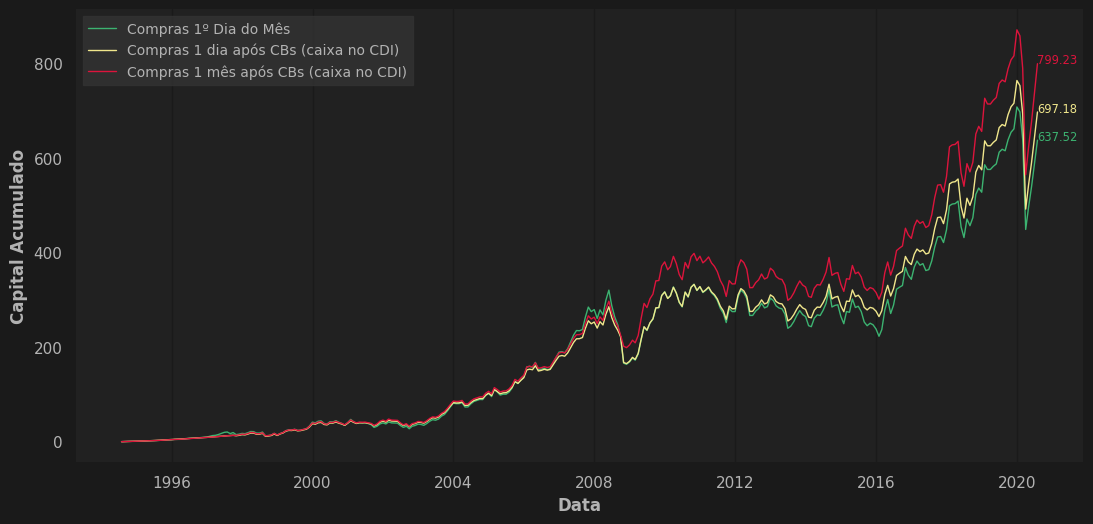

In [227]:
# Gráfico
fig, ax = plt.subplots(figsize=(13,6), dpi= 100)
ax.plot(df_cm.Total_Capital.asfreq('M', method='ffill'), c='mediumseagreen', alpha=1, linewidth=1, label='Compras 1º Dia do Mês')
ax.plot(df_cdcb.Total_Capital.asfreq('M', method='ffill'), c='khaki', alpha=1, linewidth=1, label='Compras 1 dia após CBs (caixa no CDI)')
ax.plot(df_c21dcb.Total_Capital.asfreq('M', method='ffill'), c='crimson', alpha=1, linewidth=1, label='Compras 1 mês após CBs (caixa no CDI)')
ax.legend(loc='upper left', fontsize='small', fancybox=False, facecolor='0.2', edgecolor='0.2')
ax.text(df_cm.index[-1], df_cm.Total_Capital[-1], r'%.2f' % df_cm.Total_Capital[-1], fontsize='x-small', c='mediumseagreen')
ax.text(df_cdcb.index[-1], df_cdcb.Total_Capital[-1], r'%.2f' % df_cdcb.Total_Capital[-1], fontsize='x-small', c='khaki')
ax.text(df_c21dcb.index[-1], df_c21dcb.Total_Capital[-1], r'%.2f' % df_c21dcb.Total_Capital[-1], fontsize='x-small', c='crimson')
#plt.yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Data', fontweight='bold')
ax.set_ylabel('Capital Acumulado', fontweight='bold')
ax.grid(axis='y')

In [228]:
print('Total investido: %.2f\n' % df_cm.Invested_Capital[-1])
print('Capital final com aportes no início do mês: %.2f' % df_cm.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_cm.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_cm.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%\n' % (tir_cm*100))

print('Capital final com aportes 1 dia após CBs: %.2f' % df_cdcb.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_cdcb.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_cdcb.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%' % (tir_cdcb*100))
x = (df_cdcb.Total_Capital > df_cm.Total_Capital).sum()/day_count * 100
print('Dias(%%) acima da estratégia com aportes mensais: %.2f%%\n' % x)

print('Capital final com aportes 1 mês após CBs: %.2f' % df_c21dcb.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_c21dcb.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_c21dcb.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%' % (tir_c21dcb*100))
x = (df_c21dcb.Total_Capital > df_cm.Total_Capital).sum()/day_count * 100
print('Dias(%%) acima da estratégia com aportes mensais: %.2f%%\n' % x)

Total investido: 168.55

Capital final com aportes no início do mês: 637.52
Retorno: 2736.56%
CAGR: 13.19%
TIR: 11.17%

Capital final com aportes 1 dia após CBs: 697.18
Retorno: 3154.97%
CAGR: 13.76%
TIR: 11.81%
Dias(%) acima da estratégia com aportes mensais: 65.25%

Capital final com aportes 1 mês após CBs: 799.23
Retorno: 3140.06%
CAGR: 13.74%
TIR: 12.78%
Dias(%) acima da estratégia com aportes mensais: 73.54%



In [229]:
'''df_cm.to_csv('df_cm.csv')
df_c21dcb.to_csv('df_c21dcb.csv')
df_cdcb.to_csv('df_cdcb.csv')
files.download('df_cm.csv')
files.download('df_c21dcb.csv')
files.download('df_cdcb.csv')'''

"df_cm.to_csv('df_cm.csv')\ndf_c21dcb.to_csv('df_c21dcb.csv')\ndf_cdcb.to_csv('df_cdcb.csv')\nfiles.download('df_cm.csv')\nfiles.download('df_c21dcb.csv')\nfiles.download('df_cdcb.csv')"

# **CÁLCULO DAS ESTRATÉGIAS CAIXA SEM RENDIMENTO**

In [230]:
# Dataframe com cálculos carteira compra 1 dia após circuit breakers SEM CDI
df_cdcb_no_cdi = pd.DataFrame({'Date': days})
df_cdcb_no_cdi.set_index('Date', inplace=True)

df_cdcb_no_cdi['idxDailyReturn'] = 1 + df_idx_day.PctChange

df_cdcb_no_cdi['isCB'] = df_cdcb_no_cdi.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))
df_cdcb_no_cdi['CB_count'] = df_cdcb_no_cdi.isCB.cumsum()
df_cdcb_no_cdi['Month'] = pd.to_datetime(df_cdcb_no_cdi.index).month
df_cdcb_no_cdi['Monthly_Investment'] = np.where((df_cdcb_no_cdi.Month != df_cdcb_no_cdi.Month.shift().fillna(0)), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_cdcb_no_cdi['Invested_Capital'] = df_cdcb_no_cdi.Monthly_Investment.cumsum()
df_cdcb_no_cdi['Days_Till_CB'] = df_cdcb_no_cdi.groupby((df_cdcb_no_cdi.isCB == 1).cumsum()).cumcount(ascending=False)+1

df_cdcb_no_cdi['Total_Cash'] = df_cdcb_no_cdi['Monthly_Investment']
df_cdcb_no_cdi['idx_Investment_After_CB'] = 0
df_cdcb_no_cdi['idx_Total_Capital'] = 0

for day in range(1, day_count):
  df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'Total_Cash'] = np.where(~df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day-1], 'isCB'],
                                                                         (df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day-1],'Total_Cash'] +
                                                                          df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'Monthly_Investment']), 0)
  if day+1 < day_count:
    df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'idx_Investment_After_CB'] = np.select([(df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'isCB']) &
                                                                              (df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'Month'] != df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day+1], 'Month']),
                                                                              df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'isCB']],
                                                                              [(1 * (1 + df_ipca.loc[df_ipca.index[day], 'Cumulative']) + df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'Total_Cash']) * (1 - b3_fee),
                                                                               df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'Total_Cash'] * (1 - b3_fee)], 0)
  df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'idx_Total_Capital'] = (df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day-1],'idx_Total_Capital'] + 
                                                                       df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day-1], 'idx_Investment_After_CB']) * df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day], 'idxDailyReturn']

df_cdcb_no_cdi['Total_Capital'] = df_cdcb_no_cdi.Total_Cash + df_cdcb_no_cdi.idx_Total_Capital

In [231]:
# Cálculo da rentabilidade carteira compra 1 dia após circuit breakers SEM CDI
df_cdcb_no_cdi['Valor_Cota'] = 0
df_cdcb_no_cdi['Qtde_Cotas'] = 0
df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[0],'Valor_Cota'] = valor_inicial_cota
df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[0],'Qtde_Cotas'] = df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[0],'Monthly_Investment'] / df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day],'Qtde_Cotas'] = df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day-1],'Qtde_Cotas'] + \
                                                               df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day],'Monthly_Investment'] / df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day-1],'Valor_Cota']
  df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day],'Valor_Cota'] = df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day],'Total_Capital'] / df_cdcb_no_cdi.loc[df_cdcb_no_cdi.index[day],'Qtde_Cotas']

df_cdcb_no_cdi['Return'] = df_cdcb_no_cdi.Valor_Cota / valor_inicial_cota

In [232]:
# TIR
cash_flows_cdcb_no_cdi = -df_cdcb_no_cdi.Monthly_Investment.fillna(0)
cash_flows_cdcb_no_cdi[-1] = df_cdcb_no_cdi.Total_Capital[-1]
tir_cdcb_no_cdi = xirr.xirr(dict(zip(days.date, cash_flows_cdcb_no_cdi)))

In [233]:
# Dataframe com cálculos carteira compra 21 dias após circuit breakers SEM CDI
df_c21dcb_no_cdi = pd.DataFrame({'Date': days})
df_c21dcb_no_cdi.set_index('Date', inplace=True)

df_c21dcb_no_cdi['idxDailyReturn'] = 1 + df_idx_day.PctChange

df_c21dcb_no_cdi['isCB'] = df_c21dcb_no_cdi.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))
df_c21dcb_no_cdi['isCB'] = df_c21dcb_no_cdi['isCB'].shift(dias_apos_cb - 1).fillna(False)
df_c21dcb_no_cdi['CB_count'] = df_c21dcb_no_cdi.isCB.cumsum()
df_c21dcb_no_cdi['Month'] = pd.to_datetime(df_c21dcb_no_cdi.index).month
df_c21dcb_no_cdi['Monthly_Investment'] = np.where((df_c21dcb_no_cdi.Month != df_c21dcb_no_cdi.Month.shift().fillna(0)), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_c21dcb_no_cdi['Invested_Capital'] = df_c21dcb_no_cdi.Monthly_Investment.cumsum()
df_c21dcb_no_cdi['Days_Till_CB'] = df_c21dcb_no_cdi.groupby((df_c21dcb_no_cdi.isCB == 1).cumsum()).cumcount(ascending=False)+1

df_c21dcb_no_cdi['Total_Cash'] = df_c21dcb_no_cdi['Monthly_Investment']
df_c21dcb_no_cdi['idx_Investment_Before_CB'] = 0
df_c21dcb_no_cdi['idx_Total_Capital'] = 0

for day in range(1, day_count):
  df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'Total_Cash'] = np.where(~df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day-1], 'isCB'],
                                                                         (df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day-1],'Total_Cash'] + 
                                                                          df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'Monthly_Investment']), 0)
  if day+1 < day_count:
    df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'idx_Investment_Before_CB'] = np.select([(df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'isCB']) &
                                                                              (df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'Month'] != df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day+1], 'Month']),
                                                                              df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'isCB']],
                                                                              [(1 * (1 + df_ipca.loc[df_ipca.index[day], 'Cumulative']) + df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'Total_Cash']) * (1 - b3_fee),
                                                                               df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'Total_Cash'] * (1 - b3_fee)], 0)
  df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'idx_Total_Capital'] = (df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day-1],'idx_Total_Capital'] + 
                                                                       df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day-1], 'idx_Investment_Before_CB']) * df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day], 'idxDailyReturn']

df_c21dcb_no_cdi['Total_Capital'] = df_c21dcb_no_cdi.Total_Cash + df_c21dcb_no_cdi.idx_Total_Capital

In [234]:
# Cálculo da rentabilidade carteira compra 21 dias após circuit breakers SEM CDI
df_c21dcb_no_cdi['Valor_Cota'] = 0
df_c21dcb_no_cdi['Qtde_Cotas'] = 0
df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[0],'Valor_Cota'] = valor_inicial_cota
df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[0],'Qtde_Cotas'] = df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[0],'Monthly_Investment'] / df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day],'Qtde_Cotas'] = df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day-1],'Qtde_Cotas'] + \
                                                               df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day],'Monthly_Investment'] / df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day-1],'Valor_Cota']
  df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day],'Valor_Cota'] = df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day],'Total_Capital'] / df_c21dcb_no_cdi.loc[df_c21dcb_no_cdi.index[day],'Qtde_Cotas']

df_c21dcb_no_cdi['Return'] = df_c21dcb_no_cdi.Valor_Cota / valor_inicial_cota

In [235]:
# TIR
cash_flows_c21dcb_no_cdi = -df_c21dcb_no_cdi.Monthly_Investment.fillna(0)
cash_flows_c21dcb_no_cdi[-1] = df_c21dcb_no_cdi.Total_Capital[-1]
tir_c21dcb_no_cdi = xirr.xirr(dict(zip(days.date, cash_flows_c21dcb_no_cdi)))

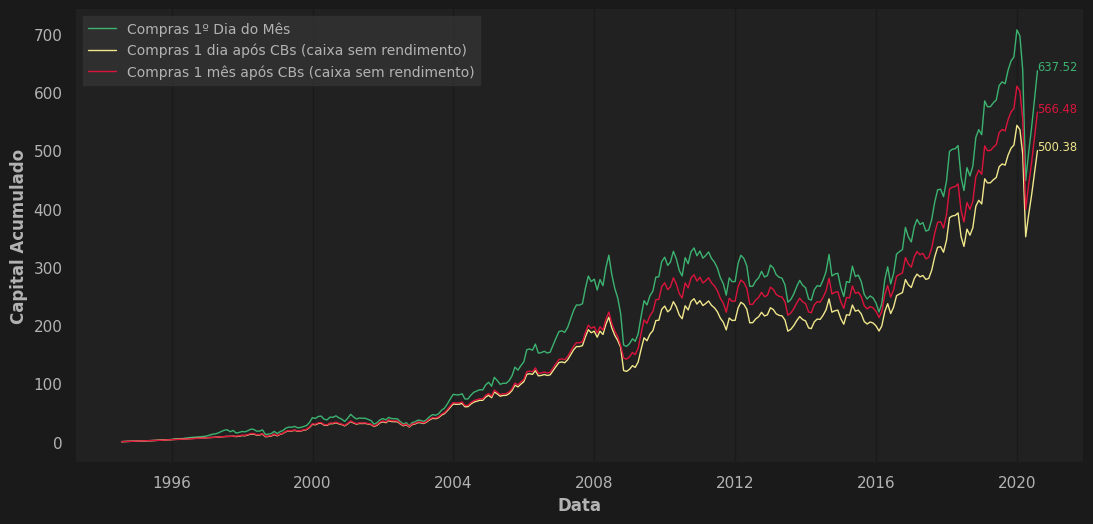

In [236]:
# Gráficos
fig, ax = plt.subplots(figsize=(13,6), dpi= 100)
ax.plot(df_cm.Total_Capital.asfreq('M', method='ffill'), c='mediumseagreen', alpha=1, linewidth=1, label='Compras 1º Dia do Mês')
ax.plot(df_cdcb_no_cdi.Total_Capital.asfreq('M', method='ffill'), c='khaki', alpha=1, linewidth=1, label='Compras 1 dia após CBs (caixa sem rendimento)')
ax.plot(df_c21dcb_no_cdi.Total_Capital.asfreq('M', method='ffill'), c='crimson', alpha=1, linewidth=1, label='Compras 1 mês após CBs (caixa sem rendimento)')
ax.legend(loc='upper left', fontsize='small', fancybox=False, facecolor='0.2', edgecolor='0.2')
ax.text(df_cm.index[-1], df_cm.Total_Capital[-1], r'%.2f' % df_cm.Total_Capital[-1], fontsize='x-small', c='mediumseagreen')
ax.text(df_cdcb_no_cdi.index[-1], df_cdcb_no_cdi.Total_Capital[-1], r'%.2f' % df_cdcb_no_cdi.Total_Capital[-1], fontsize='x-small', c='khaki')
ax.text(df_c21dcb_no_cdi.index[-1], df_c21dcb_no_cdi.Total_Capital[-1], r'%.2f' % df_c21dcb_no_cdi.Total_Capital[-1], fontsize='x-small', c='crimson')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Data', fontweight='bold')
ax.set_ylabel('Capital Acumulado', fontweight='bold')
ax.grid(axis='y')

In [237]:
print('Total investido: %.2f\n' % df_cm.Invested_Capital[-1])
print('Capital final com aportes no início do mês: %.2f' % df_cm.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_cm.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_cm.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%\n' % (tir_cm*100))

print('Capital final com aportes 1 dia após CBs: %.2f' % df_cdcb_no_cdi.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_cdcb_no_cdi.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_cdcb_no_cdi.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%' % (tir_cdcb_no_cdi*100))
x = (df_cdcb_no_cdi.Total_Capital > df_cm.Total_Capital).sum()/day_count * 100
print('Dias(%%) acima da estratégia com aportes mensais: %.2f%%\n' % x)

print('Capital final com aportes 1 mês após CBs: %.2f' % df_c21dcb_no_cdi.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_c21dcb_no_cdi.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_c21dcb_no_cdi.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%' % (tir_c21dcb_no_cdi*100))
x = (df_c21dcb_no_cdi.Total_Capital > df_cm.Total_Capital).sum()/day_count * 100
print('Dias(%%) acima da estratégia com aportes mensais: %.2f%%\n' % x)

Total investido: 168.55

Capital final com aportes no início do mês: 637.52
Retorno: 2736.56%
CAGR: 13.19%
TIR: 11.17%

Capital final com aportes 1 dia após CBs: 500.38
Retorno: 853.53%
CAGR: 8.71%
TIR: 9.39%
Dias(%) acima da estratégia com aportes mensais: 1.81%

Capital final com aportes 1 mês após CBs: 566.48
Retorno: 908.07%
CAGR: 8.93%
TIR: 10.31%
Dias(%) acima da estratégia com aportes mensais: 1.01%



In [238]:
'''df_c21dcb_no_cdi.to_csv('df_c21dcb_no_cdi.csv')
df_cdcb_no_cdi.to_csv('df_cdcb_no_cdi.csv')
files.download('df_c21dcb_no_cdi.csv')
files.download('df_cdcb_no_cdi.csv')'''

"df_c21dcb_no_cdi.to_csv('df_c21dcb_no_cdi.csv')\ndf_cdcb_no_cdi.to_csv('df_cdcb_no_cdi.csv')\nfiles.download('df_c21dcb_no_cdi.csv')\nfiles.download('df_cdcb_no_cdi.csv')"

# **CÁLCULO DAS ESTRATÉGIAS CAIXA REPONDO INFLAÇÃO**



In [239]:
# Dataframe com cálculos carteira compra 1 dia após circuit breakers REPONDO INFLAÇÃO
df_cdcb_ipca = pd.DataFrame({'Date': days})
df_cdcb_ipca.set_index('Date', inplace=True)

df_cdcb_ipca['idxDailyReturn'] = 1 + df_idx_day.PctChange
df_cdcb_ipca['IPCADailyReturn'] = 1 + df_ipca.PctChange

df_cdcb_ipca['isCB'] = df_cdcb_ipca.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))
df_cdcb_ipca['CB_count'] = df_cdcb_ipca.isCB.cumsum()
df_cdcb_ipca['Month'] = pd.to_datetime(df_cdcb_ipca.index).month
df_cdcb_ipca['CDI_Monthly_Investment'] = np.where((df_cdcb_ipca.Month != df_cdcb_ipca.Month.shift().fillna(0)), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_cdcb_ipca['Invested_Capital'] = df_cdcb_ipca.CDI_Monthly_Investment.cumsum()
df_cdcb_ipca['Days_Till_CB'] = df_cdcb_ipca.groupby((df_cdcb_ipca.isCB == 1).cumsum()).cumcount(ascending=False)+1

df_cdcb_ipca['CDI_Total_Capital'] = df_cdcb_ipca['CDI_Monthly_Investment']
df_cdcb_ipca['CDI_Tax_for_Current_Investment'] = 0
df_cdcb_ipca.loc[df_cdcb_ipca.index[0], 'CDI_Tax_for_Current_Investment'] = df_cdcb_ipca.loc[df_cdcb_ipca.index[0], 'CDI_Total_Capital'] * \
                                                                            cdi_tax_rate[df_cdcb_ipca.loc[df_cdcb_ipca.index[0], 'Days_Till_CB']] * \
                                                                            (1-cdi_iof[df_cdcb_ipca.loc[df_cdcb_ipca.index[0], 'Days_Till_CB']]) * \
                                                                            (np.prod(np.where((df_cdcb_ipca.CB_count == df_cdcb_ipca.loc[df_cdcb_ipca.index[0], 'CB_count'])  & (df_cdcb_ipca.Days_Till_CB <= df_cdcb_ipca.loc[df_cdcb_ipca.index[0], 'Days_Till_CB']), 
                                                                                              df_cdcb_ipca.IPCADailyReturn, 1)) - 1)   
df_cdcb_ipca['idx_Investment_After_CB'] = 0
df_cdcb_ipca['idx_Total_Capital'] = 0

for day in range(1, day_count):
  df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CDI_Total_Capital'] = np.where(~df_cdcb_ipca.loc[df_cdcb_ipca.index[day-1], 'isCB'],
                                                                   (df_cdcb_ipca.loc[df_cdcb_ipca.index[day-1],'CDI_Total_Capital'] + df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CDI_Monthly_Investment']) * \
                                                                    df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'IPCADailyReturn'], 0)
  df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CDI_Tax_for_Current_Investment'] = df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CDI_Monthly_Investment'] * \
                                                                    cdi_tax_rate[df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'Days_Till_CB']] * \
                                                                    (1-cdi_iof[df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'Days_Till_CB']]) * \
                                                                    (np.prod(np.where((df_cdcb_ipca.CB_count == df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CB_count'])  & (df_cdcb_ipca.Days_Till_CB <= df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'Days_Till_CB']), 
                                                                                      df_cdcb_ipca.IPCADailyReturn, 1)) - 1)                                          
  if day+1 < day_count:  
    df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'idx_Investment_After_CB'] = np.select([(df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'isCB']) &
                                                                          (df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'Month'] != df_cdcb_ipca.loc[df_cdcb_ipca.index[day+1], 'Month']),
                                                                          df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'isCB']],
                                                                        [(1 * (1 + df_ipca.loc[df_ipca.index[day], 'Cumulative']) + (df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CDI_Total_Capital'] - 
                                                                        np.sum(np.where(df_cdcb_ipca.CB_count == df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CB_count'], df_cdcb_ipca.CDI_Tax_for_Current_Investment, 0)))) * (1 - b3_fee),
                                                                         (df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CDI_Total_Capital'] - 
                                                                        np.sum(np.where(df_cdcb_ipca.CB_count == df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'CB_count'], df_cdcb_ipca.CDI_Tax_for_Current_Investment, 0))) * (1 - b3_fee)], 0)
  df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'idx_Total_Capital'] =  (df_cdcb_ipca.loc[df_cdcb_ipca.index[day-1],'idx_Total_Capital'] + 
                                                   df_cdcb_ipca.loc[df_cdcb_ipca.index[day-1], 'idx_Investment_After_CB']) * df_cdcb_ipca.loc[df_cdcb_ipca.index[day], 'idxDailyReturn']

df_cdcb_ipca['Total_Capital'] = df_cdcb_ipca.CDI_Total_Capital + df_cdcb_ipca.idx_Total_Capital

In [240]:
# Cálculo da rentabilidade carteira compra 1 dia após circuit breakers REPONDO INFLAÇÃO
df_cdcb_ipca['Valor_Cota'] = 0
df_cdcb_ipca['Qtde_Cotas'] = 0
df_cdcb_ipca.loc[df_cdcb_ipca.index[0],'Valor_Cota'] = valor_inicial_cota
df_cdcb_ipca.loc[df_cdcb_ipca.index[0],'Qtde_Cotas'] = df_cdcb_ipca.loc[df_cdcb_ipca.index[0],'CDI_Monthly_Investment'] / df_cdcb_ipca.loc[df_cdcb_ipca.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_cdcb_ipca.loc[df_cdcb_ipca.index[day],'Qtde_Cotas'] = df_cdcb_ipca.loc[df_cdcb_ipca.index[day-1],'Qtde_Cotas'] + \
                                                 df_cdcb_ipca.loc[df_cdcb_ipca.index[day],'CDI_Monthly_Investment'] / df_cdcb_ipca.loc[df_cdcb_ipca.index[day-1],'Valor_Cota']
  df_cdcb_ipca.loc[df_cdcb_ipca.index[day],'Valor_Cota'] = df_cdcb_ipca.loc[df_cdcb_ipca.index[day],'Total_Capital'] / df_cdcb_ipca.loc[df_cdcb_ipca.index[day],'Qtde_Cotas']

df_cdcb_ipca['Return'] = df_cdcb_ipca.Valor_Cota / valor_inicial_cota

In [241]:
# TIR
cash_flows_cdcb_ipca = -df_cdcb_ipca.CDI_Monthly_Investment.fillna(0)
cash_flows_cdcb_ipca[-1] = df_cdcb_ipca.Total_Capital[-1]
tir_cdcb_ipca = xirr.xirr(dict(zip(days.date, cash_flows_cdcb_ipca)))

In [242]:
# Dataframe com cálculos carteira compra 21 dias após circuit breakers REPONDO INFLAÇÃO
df_c21dcb_ipca = pd.DataFrame({'Date': days})
df_c21dcb_ipca.set_index('Date', inplace=True)

df_c21dcb_ipca['idxDailyReturn'] = 1 + df_idx_day.PctChange
df_c21dcb_ipca['IPCADailyReturn'] = 1 + df_ipca.PctChange

df_c21dcb_ipca['isCB'] = df_c21dcb_ipca.index.isin(pd.to_datetime(circuit_breakers_dates, format='%d/%m/%Y'))
df_c21dcb_ipca['isCB'] = df_c21dcb_ipca['isCB'].shift(dias_apos_cb - 1).fillna(False)
df_c21dcb_ipca['CB_count'] = df_c21dcb_ipca.isCB.cumsum()
df_c21dcb_ipca['Month'] = pd.to_datetime(df_c21dcb_ipca.index).month
df_c21dcb_ipca['CDI_Monthly_Investment'] = np.where((df_c21dcb_ipca.Month != df_c21dcb_ipca.Month.shift().fillna(0)), 1, 0) / (1 + df_ipca.RateUntilPresent)
df_c21dcb_ipca['Invested_Capital'] = df_c21dcb_ipca.CDI_Monthly_Investment.cumsum()
df_c21dcb_ipca['Days_Till_CB'] = df_c21dcb_ipca.groupby((df_c21dcb_ipca.isCB == 1).cumsum()).cumcount(ascending=False)+1

df_c21dcb_ipca['CDI_Total_Capital'] = df_c21dcb_ipca['CDI_Monthly_Investment']
df_c21dcb_ipca['CDI_Tax_for_Current_Investment'] = 0
df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0], 'CDI_Tax_for_Current_Investment'] = df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0], 'CDI_Total_Capital'] * \
                                                                            cdi_tax_rate[df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0], 'Days_Till_CB']] * \
                                                                            (1-cdi_iof[df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0], 'Days_Till_CB']]) * \
                                                                            (np.prod(np.where((df_c21dcb_ipca.CB_count == df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0], 'CB_count'])  & (df_c21dcb_ipca.Days_Till_CB <= df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0], 'Days_Till_CB']), 
                                                                                              df_c21dcb_ipca.IPCADailyReturn, 1)) - 1)   
df_c21dcb_ipca['idx_Investment_After_CB'] = 0
df_c21dcb_ipca['idx_Total_Capital'] = 0

for day in range(1, day_count):
  df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CDI_Total_Capital'] = np.where(~df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day-1], 'isCB'],
                                                                   (df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day-1],'CDI_Total_Capital'] + df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CDI_Monthly_Investment']) * \
                                                                    df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'IPCADailyReturn'], 0)
  df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CDI_Tax_for_Current_Investment'] = df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CDI_Monthly_Investment'] * \
                                                                    cdi_tax_rate[df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'Days_Till_CB']] * \
                                                                    (1-cdi_iof[df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'Days_Till_CB']]) * \
                                                                    (np.prod(np.where((df_c21dcb_ipca.CB_count == df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CB_count'])  & (df_c21dcb_ipca.Days_Till_CB <= df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'Days_Till_CB']), 
                                                                                      df_c21dcb_ipca.IPCADailyReturn, 1)) - 1)                                          
  if day+1 < day_count:  
    df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'idx_Investment_After_CB'] = np.select([(df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'isCB']) &
                                                                          (df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'Month'] != df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day+1], 'Month']),
                                                                          df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'isCB']],
                                                                        [(1 * (1 + df_ipca.loc[df_ipca.index[day], 'Cumulative']) + (df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CDI_Total_Capital'] - 
                                                                        np.sum(np.where(df_c21dcb_ipca.CB_count == df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CB_count'], df_c21dcb_ipca.CDI_Tax_for_Current_Investment, 0)))) * (1 - b3_fee),
                                                                         (df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CDI_Total_Capital'] - 
                                                                        np.sum(np.where(df_c21dcb_ipca.CB_count == df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'CB_count'], df_c21dcb_ipca.CDI_Tax_for_Current_Investment, 0))) * (1 - b3_fee)], 0)
  df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'idx_Total_Capital'] =  (df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day-1],'idx_Total_Capital'] + 
                                                   df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day-1], 'idx_Investment_After_CB']) * df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day], 'idxDailyReturn']

df_c21dcb_ipca['Total_Capital'] = df_c21dcb_ipca.CDI_Total_Capital + df_c21dcb_ipca.idx_Total_Capital

In [243]:
# Cálculo da rentabilidade carteira compra 21 dias após circuit breakers REPONDO INFLAÇÃO
df_c21dcb_ipca['Valor_Cota'] = 0
df_c21dcb_ipca['Qtde_Cotas'] = 0
df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0],'Valor_Cota'] = valor_inicial_cota
df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0],'Qtde_Cotas'] = df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0],'CDI_Monthly_Investment'] / df_c21dcb_ipca.loc[df_c21dcb_ipca.index[0],'Valor_Cota']

for day in range(1, day_count):
  df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day],'Qtde_Cotas'] = df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day-1],'Qtde_Cotas'] + \
                                                 df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day],'CDI_Monthly_Investment'] / df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day-1],'Valor_Cota']
  df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day],'Valor_Cota'] = df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day],'Total_Capital'] / df_c21dcb_ipca.loc[df_c21dcb_ipca.index[day],'Qtde_Cotas']

df_c21dcb_ipca['Return'] = df_c21dcb_ipca.Valor_Cota / valor_inicial_cota

In [244]:
# TIR
cash_flows_c21dcb_ipca = -df_c21dcb_ipca.CDI_Monthly_Investment.fillna(0)
cash_flows_c21dcb_ipca[-1] = df_c21dcb_ipca.Total_Capital[-1]
tir_c21dcb_ipca = xirr.xirr(dict(zip(days.date, cash_flows_c21dcb_ipca)))

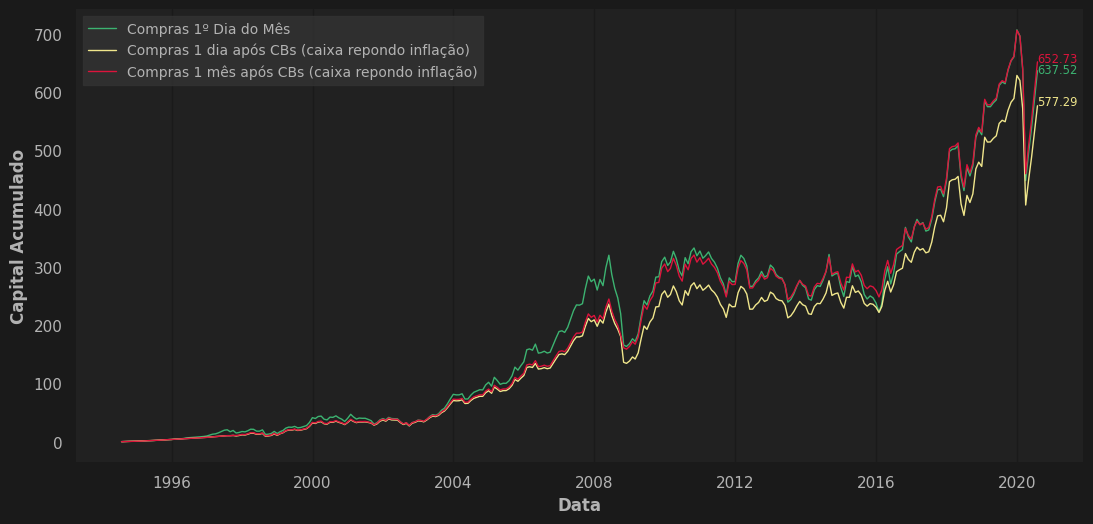

In [245]:
# Gráfico
fig, ax = plt.subplots(figsize=(13,6), dpi= 100)
ax.plot(df_cm.Total_Capital.asfreq('M', method='ffill'), c='mediumseagreen', alpha=1, linewidth=1, label='Compras 1º Dia do Mês')
ax.plot(df_cdcb_ipca.Total_Capital.asfreq('M', method='ffill'), c='khaki', alpha=1, linewidth=1, label='Compras 1 dia após CBs (caixa repondo inflação)')
ax.plot(df_c21dcb_ipca.Total_Capital.asfreq('M', method='ffill'), c='crimson', alpha=1, linewidth=1, label='Compras 1 mês após CBs (caixa repondo inflação)')
ax.text(df_cm.index[-1], df_cm.Total_Capital[-1]-4, r'%.2f' % df_cm.Total_Capital[-1], fontsize='x-small', c='mediumseagreen')
ax.text(df_cdcb_ipca.index[-1], df_cdcb_ipca.Total_Capital[-1]+1, r'%.2f' % df_cdcb_ipca.Total_Capital[-1], fontsize='x-small', c='khaki')
ax.text(df_c21dcb_ipca.index[-1], df_c21dcb_ipca.Total_Capital[-1], r'%.2f' % df_c21dcb_ipca.Total_Capital[-1], fontsize='x-small', c='crimson')
ax.legend(loc='upper left', fontsize='small', fancybox=False, facecolor='0.2', edgecolor='0.2')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Data', fontweight='bold')
ax.set_ylabel('Capital Acumulado', fontweight='bold')
ax.grid(axis='y')

In [246]:
print('Total investido: %.2f\n' % df_cm.Invested_Capital[-1])
print('Capital final com aportes no início do mês: %.2f' % df_cm.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_cm.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_cm.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%\n' % (tir_cm*100))

print('Capital final com aportes 1 dia após CBs: %.2f' % df_cdcb_ipca.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_cdcb_ipca.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_cdcb_ipca.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%' % (tir_cdcb_ipca*100))
x = (df_cdcb_ipca.Total_Capital > df_cm.Total_Capital).sum()/day_count * 100
print('Dias(%%) acima da estratégia com aportes mensais: %.2f%%\n' % x)

print('Capital final com aportes 1 mês após CBs: %.2f' % df_c21dcb_ipca.Total_Capital[-1])
print('Retorno: %.2f%%' % ((df_c21dcb_ipca.Return[-1]-1) * 100))
print('CAGR: %.2f%%' % ((df_c21dcb_ipca.Return[-1] ** (252 / day_count) - 1) * 100))
print('TIR: %.2f%%' % (tir_c21dcb_ipca*100))
x = (df_c21dcb_ipca.Total_Capital > df_cm.Total_Capital).sum()/day_count * 100
print('Dias(%%) acima da estratégia com aportes mensais: %.2f%%\n' % x)

Total investido: 168.55

Capital final com aportes no início do mês: 637.52
Retorno: 2736.56%
CAGR: 13.19%
TIR: 11.17%

Capital final com aportes 1 dia após CBs: 577.29
Retorno: 1578.84%
CAGR: 11.01%
TIR: 10.45%
Dias(%) acima da estratégia com aportes mensais: 3.69%

Capital final com aportes 1 mês após CBs: 652.73
Retorno: 1606.94%
CAGR: 11.08%
TIR: 11.34%
Dias(%) acima da estratégia com aportes mensais: 28.62%



In [247]:
'''df_c21dcb_ipca.to_csv('df_c21dcb_ipca.csv')
df_cdcb_ipca.to_csv('df_cdcb_ipca.csv')
files.download('df_c21dcb_ipca.csv')
files.download('df_cdcb_ipca.csv')'''

"df_c21dcb_ipca.to_csv('df_c21dcb_ipca.csv')\ndf_cdcb_ipca.to_csv('df_cdcb_ipca.csv')\nfiles.download('df_c21dcb_ipca.csv')\nfiles.download('df_cdcb_ipca.csv')"